# Similarity Search

In this part of the notebook, we compute the structural fingerprints of our compounds. Afterward, we identify the compounds with the highest similarity to our control using the Euclidean distance of both the morphological and structural fingerprints.

##  Import libraries and previous data

In [1]:

import pickle
import warnings

import numpy as np
import pandas as pd
from rdkit import RDLogger
import plotly_express as px
from scipy.spatial import distance
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize




### Load data : per-treatment profile

The file loaded contains the normalized and aggregated profile per treatment compound obtained previously in [Part1-Data_Processing](Part1-Data_Processing). <br>
Data is stored in the folder [Output](../Data/Output/output_notebook_1.pkl) under _output_notebook_1.pkl_.

In [2]:
path_to_pickle_file ='../Data/Output/output_notebook_1.pkl'
z_score_agreg = pickle.load(open(path_to_pickle_file, 'rb'))

z_score_agreg.head(2)

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,...,Nuclei_Texture_InfoMeas1_RNA_10_0,Nuclei_Texture_InfoMeas1_RNA_3_0,Nuclei_Texture_InverseDifferenceMoment_ER_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_3_0,Nuclei_Texture_SumAverage_AGP_10_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_RNA_10_0
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.048557,1.511709,0.671319,1.608394,-0.511233,0.565885,0.257311,...,-0.161772,-1.539330,-0.258078,1.686230,0.750015,0.074106,0.586195,1.125321,1.009055,-1.088308
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.452500,0.951801,0.099539,0.742502,-0.953422,-0.629503,0.145339,...,-0.386151,-0.748133,0.542511,1.586065,-1.109089,0.157262,-0.662275,-0.373907,1.198932,-0.733997


For this  part the DMSO profile won't be necessary so for it not to appear within the similarity search we will extract the profile from the dataframe

In [3]:
DMSO = z_score_agreg.loc[z_score_agreg['CPD_NAME'] == 'DMSO']
z_score_agreg.drop(DMSO.index,inplace=True)
z_score_agreg.reset_index(drop=True,inplace=True)

In [4]:
morpho_profile = z_score_agreg.copy(deep=True)

A different example of molecules having the same names but different sample IDs as anabasine in Notebook 1:[Part1_Data_Processing](Part1_Data_Processing).

In [5]:
morpho_profile[morpho_profile['CPD_NAME']=='propranolol']['Metadata_broad_sample']

22408    BRD-A10070317-003-05-1
23178    BRD-K13994703-001-02-0
27229    BRD-K92830582-003-04-8
Name: Metadata_broad_sample, dtype: object

## Structural Fingerprints 

1. Pre-processing SMILES

Pre-processing structural fingerprints aims to clean the smiles, un-charge them and canonicalize them.
Here is a Notebook on how to use the rdMolStandardize module in Rdkit: [Standardization Smile ](https://github.com/rdkit/rdkit/blob/master/Docs/Notebooks/MolStandardize.ipynb)

In [6]:
def clean_std_smiles(dataset):
    '''
    Standardize (Cleanup) and canonicalize parent smiles
        Parameters : 
            dataset (data frame): data frame having a column named 'CPD_SMILES' with smiles
        Returns : 
            dataset (data frame): same data frame with one more column named 'STD_smile'
    '''
    
    RDLogger.DisableLog('rdApp.info')
    object = dataset['CPD_SMILES'].apply(Chem.MolFromSmiles)
    #Standardizes the molecule list
    clean_mol = [rdMolStandardize.Cleanup(mol) for mol in object ] 
    #Returns the largest fragment after doing a cleanup
    parent_clean_mol = [rdMolStandardize.FragmentParent(mol) for mol in clean_mol] 

    smile = list(map(Chem.MolToSmiles,parent_clean_mol))
    dataset['STD_smile'] = smile

    return dataset

In [7]:
profiles = clean_std_smiles(morpho_profile)

Now the dataframe profiles contains a column with standardized and canonical smiles

2. Convert smiles to Morgan fingerprint

Morgan fingerprint is a way to represent chemical compounds in a computer-friendly format, which takes the structure of a molecule and converts it into a series of numbers or bits, capturing the presence of certain structural features.

Here we implement two functions : 
- One to instantiate Morgan fingerprints generator; _morgan_bin_
- One that call and computes the binary morgan fingerprint and happened it to the data frame; _make_fps_

In [8]:
def morgan_bin(fpg,dataset):
    
    '''
    Generate Morgan fingerprints as binary vector  
        Parameters : 
            fpg (object): rdFingerprintGenerator(radius=X,fpSize=X) object generated by make_fps()
            dataset (data frame): data frame having a column named 'STD_smile' with smiles
        Returns : 
            dataset (data frame): same data frame with one more column named 'morganB_fps' within a list
    '''     
    RDLogger.DisableLog('rdApp.info')
    circular_bit_fp = [fpg.GetFingerprint(Chem.MolFromSmiles(smiles)).ToList() for smiles in dataset['STD_smile']]
    dataset['morganB_fps'] =  circular_bit_fp
    
    return dataset

def make_fps(dataset,val_radius=2,n_bits=1024):
    
    '''
    Make fingerprints is the function call to create structural fingerprints, combine morphological fingerprints etc 
        Parameters : 
            dataset_profiles (data frame): initial dataset having the morphological profiles  
            val_radius (int):  default = 2 can be changed, used to make morgan fingerprint cf GetMorganGenerator() Rdkit function 
            n_bits (int): default = 1024 can be changed, used to make morgan fingerprint cf GetMorganGenerator() Rdkit function 
        Returns : 
            dataset (data frame): initial dataset with a supplementary column containing the newly generated fps -> to drop before running make_models for a different fps 
    ''' 
    RDLogger.DisableLog('rdApp.info')
    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=val_radius, fpSize=n_bits)
    dataset = morgan_bin(fpg,dataset)


    return dataset

Now we can call the above function and  generate morgan fingerprint dataframe 

In [9]:
profiles_morgan = make_fps(dataset = profiles)

## Hands-on: Similarity search

For similarity search we will select a query, a molecule for which we want to identify other similar compounds in both, the chemical and morphological library of profiles.

1. Define a query

In [10]:
query_name = 'estriol' #'progesterone' #'testosterone' #'tamoxifen' #'estriol'
profiles[profiles['CPD_NAME'] == query_name ]

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,...,Nuclei_Texture_InverseDifferenceMoment_ER_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_3_0,Nuclei_Texture_SumAverage_AGP_10_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_RNA_10_0,STD_smile,morganB_fps
23228,BRD-K17016787-001-03-5,estriol,C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1C[...,0.782789,0.50802,-0.144755,0.933463,0.023946,-0.146667,0.803995,...,0.169978,-0.326561,0.725277,0.308343,0.78206,-0.722963,0.285099,0.039748,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
idx_ref = profiles[profiles['CPD_NAME'] == query_name ].index.to_list()[0]
print(f'The selected query is {query_name}, its index  in profiles dataset is {idx_ref}')

The selected query is estriol, its index  in profiles dataset is 23228


2. Compute distance 

In [12]:
def calculate_distances(dataframe: pd.DataFrame, fingerprint_type: str, idx_ref: int, distance_metric: str = 'euclidean') -> pd.DataFrame:
    '''
    Calculate the distance between the reference compound and all other compounds in the dataframe based on a specified fingerprint type and distance metric.

    Parameters:
    -----------
        data frame (pd.DataFrame): A pandas DataFrame containing the fingerprints.
        fingerprint_type (str): The column name indicating the fingerprint to be considered for the calculation.
        idx_ref (int): The index of the reference compound.
        distance_metric (str, optional): The metric used for distance calculation. Available options: 'euclidean', 'tanimoto'. Defaults to 'euclidean'.

    Returns:
    --------
        pd.DataFrame: The input data frame with an additional column containing the distances to the reference compound.
    '''
    #initialize an empty list to store computed distances
    distances = []
    # convert the fingerprint of our query into a Numpy Array
    fp_ref = np.asarray(dataframe.loc[idx_ref, fingerprint_type], dtype=np.float64)
    
    # Iterate over each index (i.e. molecules) in the data frame
    for i in dataframe.index:
        compare_fp = np.array(dataframe.loc[i, fingerprint_type], dtype=np.float64)
        
        # compute distance based on the specified distance metric
        if distance_metric == 'euclidean':
            dis = distance.euclidean(fp_ref, compare_fp)
            distances.append(dis)
        elif distance_metric == 'tanimoto':
            dis = distance.rogerstanimoto(fp_ref, compare_fp)  # Calculates Tanimoto dissimilarity
            distances.append(dis)

    # Add a new column to the input dataframe with the calculated distance 
    dataframe[f'{distance_metric}_distance_{fingerprint_type}'] = distances
    return dataframe


> _A. Using Euclidean distance_

If one want to run the code with a different query, one need to assure to delete the new colunm added to the dataframe, so they are not use to compute similarity 

In [13]:

# List of columns to check and drop
columns_to_drop = ["euclidean_distance_morganB_fps","tanimoto_distance_morganB_fps","morphological_fingerprint","euclidean_distance_morphological_fingerprint"]

# Check if columns exist and drop them
profiles_morgan = profiles_morgan.drop(columns=[col for col in columns_to_drop if col in profiles_morgan.columns])

In [14]:
profiles_morgan  = calculate_distances(dataframe=profiles_morgan , fingerprint_type='morganB_fps', idx_ref=idx_ref) 

In [15]:
furthest = profiles_morgan.sort_values('euclidean_distance_morganB_fps', ascending=False)
furthest_20_morgan = furthest['CPD_NAME'].values[:20] # the int value can be changed 

The list of closest compounds will feature deferoxamine at position 0. We take into account positions 0-21 to

In [16]:
closest = profiles_morgan.sort_values('euclidean_distance_morganB_fps', ascending=True)
closest_20_morgan = closest['CPD_NAME'].values[1:11]

> _B. Using Tanimoto distance_

In [17]:
profiles_morgan  = calculate_distances(dataframe=profiles_morgan , fingerprint_type='morganB_fps', idx_ref=idx_ref, distance_metric='tanimoto') 
furthest = profiles_morgan.sort_values('tanimoto_distance_morganB_fps', ascending=False)
closest = profiles_morgan.sort_values('tanimoto_distance_morganB_fps', ascending=True)

## Visualise furthest and closest molecule 

In [18]:

def draw_molecules(smiles_list, legends):
    ''' 
    Draws a grid image of molecules from a list of SMILES strings with corresponding legends.

    Parameters:
    ----------
        smiles_list (list of str): A list of SMILES strings representing the molecules.
        legends (list of str): A list of legends corresponding to each molecule.
        mols_per_row (int): The number of molecules to draw per row in the grid (default is 4).

    Returns:
    -------
        PIL.Image.Image: An image object containing the grid of drawn molecules.
    '''
    mol_list = []
    for smile in smiles_list:
        mol_list.append(Chem.MolFromSmiles(smile))
    return Draw.MolsToGridImage(mols=mol_list, molsPerRow=5, legends=legends)

### On structural fingerprint

1. Visualise furthest molecule from structural point of view

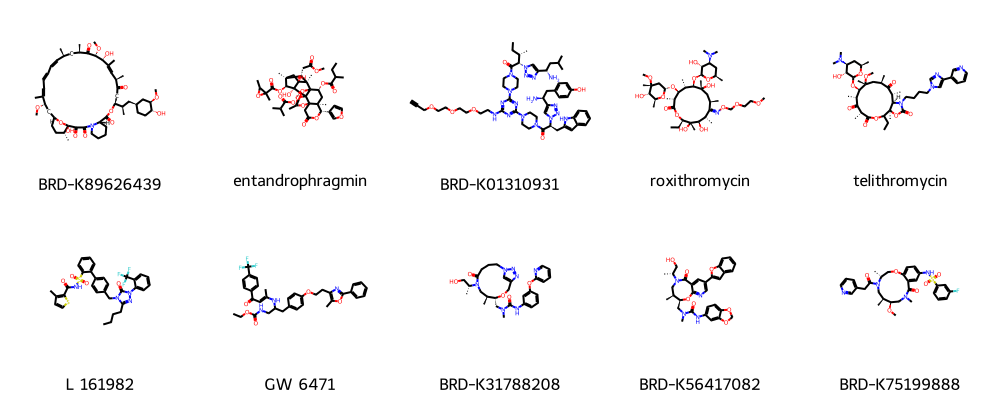

In [19]:
smiles_list =  furthest['STD_smile'].values[:10]
legends = list(furthest_20_morgan)
img = draw_molecules(smiles_list, legends)
img

2. Visualise closest molecule from structural point of view

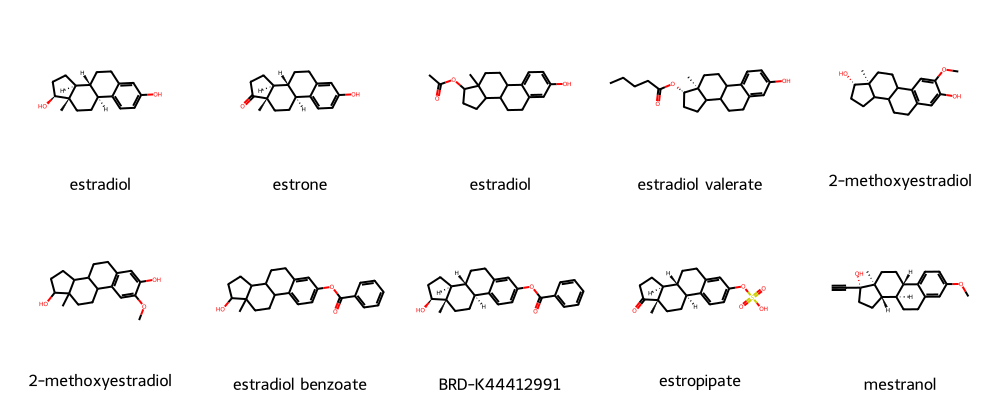

In [20]:
smiles_list =  closest['STD_smile'].values[1:11]
legends = list(closest_20_morgan)
img = draw_molecules(smiles_list, legends)
img

### On morphological fingerprint

> NB : the distance here is computed on the morphological fingerprint but we are showing in this part the molecule that matches the query search

In [21]:
idx_ref = profiles_morgan[profiles_morgan['CPD_NAME'] == query_name].index.to_list()[0]

We collapse all morphological features into one column and convert all values to float (i.e., floating point numbers)

In [22]:
morph_fingerprint_cols = profiles_morgan.columns
for col in ['euclidean_distance_morganB_fps', 'morganB_fps', 'STD_smile', 'CPD_NAME', 'CPD_SMILES','Metadata_broad_sample','tanimoto_distance_morganB_fps']:
    index = np.argwhere(morph_fingerprint_cols == col)
    morph_fingerprint_cols = np.delete(morph_fingerprint_cols, index)

In [23]:
dim = z_score_agreg.shape[0]
profiles_morgan['morphological_fingerprint'] = np.empty(dim)
profiles_morgan['morphological_fingerprint'] = profiles_morgan.apply(lambda x: x[morph_fingerprint_cols].values.astype(np.float64), axis=1)

### A. Using Euclidean distance and morphological fingerprint features 

In [24]:
profiles_morgan  = calculate_distances(dataframe = profiles_morgan , fingerprint_type = 'morphological_fingerprint', idx_ref=idx_ref)

In [25]:
furthest = profiles_morgan.sort_values('euclidean_distance_morphological_fingerprint', ascending=False)
furthest_20_morpholgical_fp = furthest['CPD_NAME'].values[:20]

The list of closest compounds will feature the query at position 0. We take into account positions 1-n to

In [26]:
closest = profiles_morgan.sort_values('euclidean_distance_morphological_fingerprint', ascending=True)
closest_20_morpholgical_fp = closest['CPD_NAME'].values[1:11]

1. Visualise furthest molecule from morphological point of view

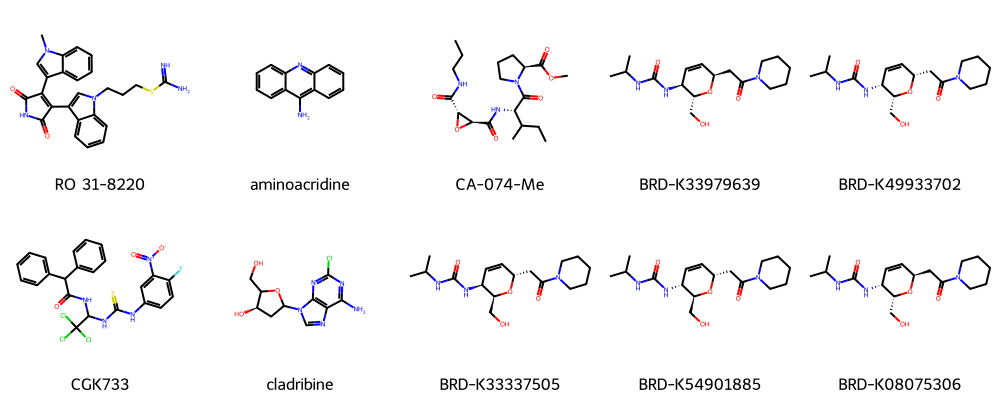

In [27]:
smiles_list =  furthest['STD_smile'].values[0:10]
legends = list(furthest_20_morpholgical_fp)
img = draw_molecules(smiles_list, legends)
img


2. Visualise closest molecule from morphological point of view

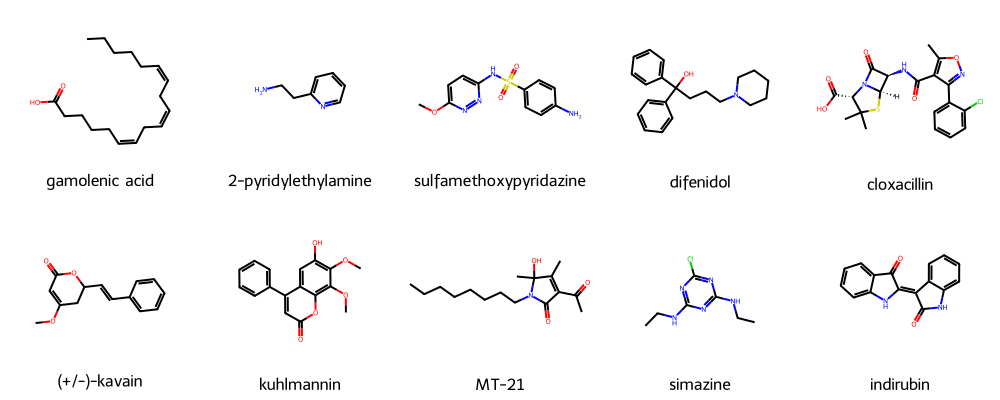

In [28]:
smiles_list =  closest['STD_smile'].values[1:11]
legends = list(closest_20_morpholgical_fp)
img = draw_molecules(smiles_list, legends)
img


## Pickle Fingerprint Dataframe

This data frame will be used in [Part3-Machine_Learning](Part3-Machine_Learning).

In [29]:
profiles_morgan.to_pickle('../Data/Output/output_notebook_2.pkl') 

## Morphological fingerprint representation 

The section above demonstrates how to find the closest molecule to a query based on Euclidean distance computed using either structural fingerprints, such as Morgan fingerprints, or morphological fingerprints. The results were output as molecules. Here, we will quickly show the same results using morphological fingerprints by i) overlapping the profile of our query with the closest and furthest matches, and ii) displaying the matches with a barcode representation.

1. Overlapped profile 

In [30]:
z_score_agreg.head(2)

,Metadata_broad_sample,CPD_NAME,CPD_SMILES,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Perimeter,...,Nuclei_Texture_InfoMeas1_RNA_10_0,Nuclei_Texture_InfoMeas1_RNA_3_0,Nuclei_Texture_InverseDifferenceMoment_ER_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_3_0,Nuclei_Texture_SumAverage_AGP_10_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_RNA_10_0
0,BRD-K08693008-001-01-9,BRD-K08693008,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@@H]1...,0.048557,1.511709,0.671319,1.608394,-0.511233,0.565885,0.257311,...,-0.161772,-1.539330,-0.258078,1.686230,0.750015,0.074106,0.586195,1.125321,1.009055,-1.088308
1,BRD-K63982890-001-01-9,BRD-K63982890,OC[C@@H]1O[C@@H](CCn2cc(nn2)C2CCCCC2)CC[C@H]1N...,-0.452500,0.951801,0.099539,0.742502,-0.953422,-0.629503,0.145339,...,-0.386151,-0.748133,0.542511,1.586065,-1.109089,0.157262,-0.662275,-0.373907,1.198932,-0.733997


In [31]:
query = z_score_agreg[z_score_agreg['CPD_NAME'] == query_name].head(1)
closest_query = z_score_agreg[z_score_agreg['CPD_NAME'] == closest_20_morpholgical_fp[0]].head(1)
furthest_query = z_score_agreg[z_score_agreg['CPD_NAME'] == furthest_20_morpholgical_fp[0]].head(1)

In [32]:
overlapped_profile = pd.concat([query,closest_query,furthest_query])


In [33]:
superimpo = overlapped_profile.iloc[:,3:].T
superimpo.columns = overlapped_profile['CPD_NAME'].to_list()

Let's look at the correlation between the query, its closest and furthest match : 

In [34]:
superimpo.corr(method='pearson')

,estriol,gamolenic acid,RO 31-8220
estriol,1.000000,0.803337,-0.010025
gamolenic acid,0.803337,1.000000,-0.066638
RO 31-8220,-0.010025,-0.066638,1.000000


In [35]:
# This feature is dropped for this case only because the value is too high and we can't visualize the profile properly)
superimpo.drop(labels='Cytoplasm_Texture_Entropy_DNA_5_0',axis=0,inplace=True)

In [36]:
# Super imposition of profiles
profiles_lines = px.line(superimpo , x=superimpo.index, y=superimpo.iloc[:,0],title="Profile superimposition ") 

profiles_lines.add_scatter(x=superimpo.index, y = superimpo.iloc[:,1])
profiles_lines.data[-1].name = superimpo.columns[1]

profiles_lines.add_scatter(x=superimpo.index, y = superimpo.iloc[:,2])
profiles_lines.data[-1].name = superimpo.columns[2]


profiles_lines.show()

2. Morphological profiles as heatmap barcode

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df = superimpo.T

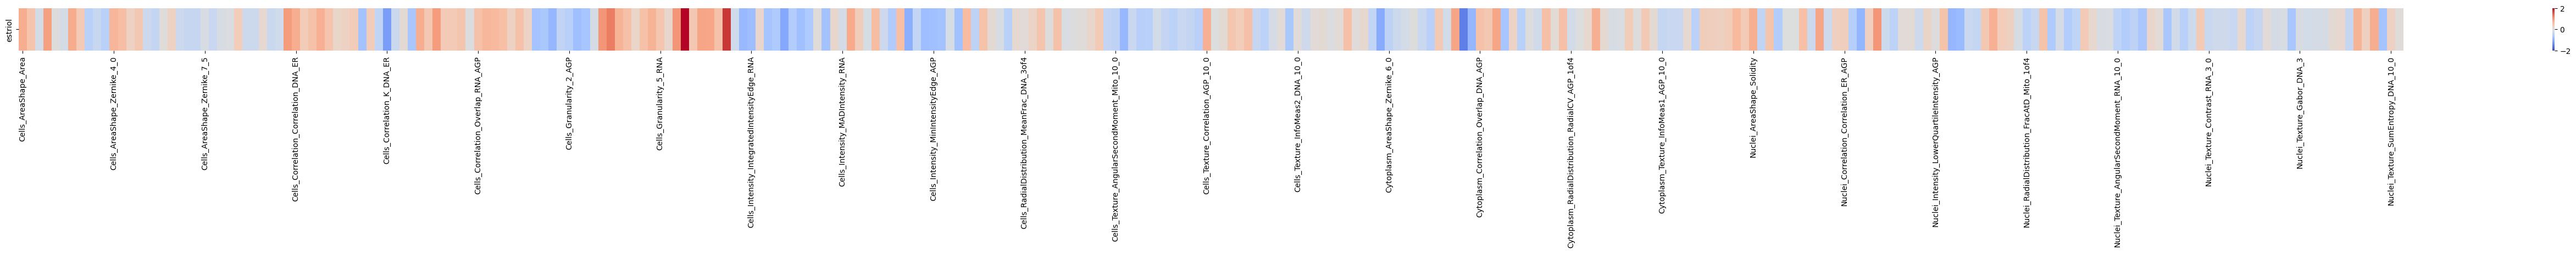

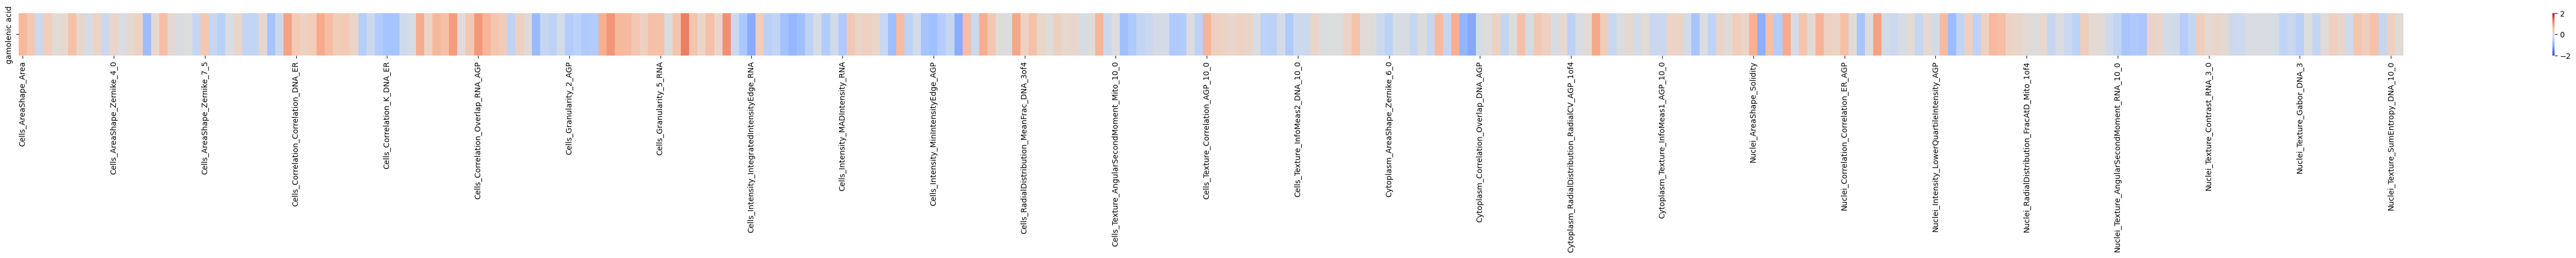

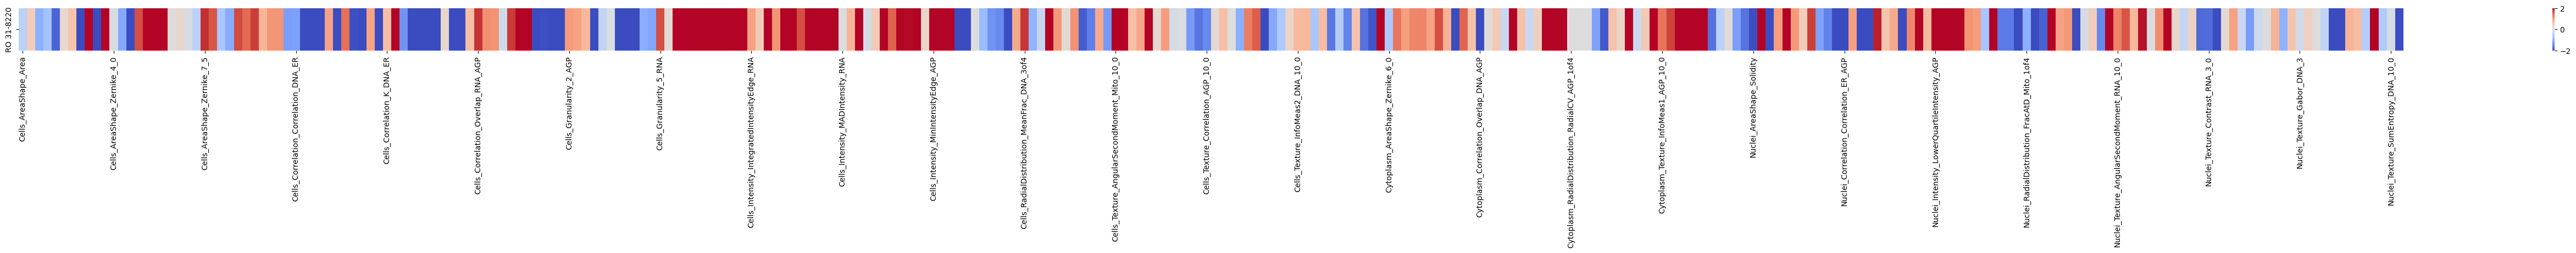

In [39]:
# heatmap of query
query = sns.heatmap(df[(df.index==df.index[0])],cmap='coolwarm',vmin=-2,vmax=2)
plt.gcf().set_size_inches(70,1)
fig = query.get_figure()
plt.show()

# heatmap of the closest match

query = sns.heatmap(df[(df.index==df.index[1])],cmap='coolwarm',vmin=-2,vmax=2)
plt.gcf().set_size_inches(70,1)
fig = query.get_figure()
plt.show()

# heatmap of the furthest match
query = sns.heatmap(df[(df.index==df.index[2])],cmap='coolwarm',vmin=-2,vmax=2)
plt.gcf().set_size_inches(70,1)
fig = query.get_figure()
plt.show()





### Discussion on Fingerprint Similarity

We calculated the closest and furthest compounds to the reference according to the Euclidian distance. This was done using two types of fingerprints, i.e., structural (Morgan) and morphological fingerprints. Now, we want to see how the lists intersect.

In [40]:
print(f'{len(set(furthest_20_morgan).intersection(set(furthest_20_morpholgical_fp)))} compounds are in the list of the 20 furthest compounds according to both: morgan and morphological fingerprints.')


0 compounds are in the list of the 20 furthest compounds according to both: morgan and morphological fingerprints.


It appears that neither list contains any shared compounds, suggesting that the Euclidean distance between fingerprints may not provide the definitive list of most similar compounds.<br>

The lack of cross-referenced information here may indicate complementary information for structure-activity or morphology-mechanism of action (MOA) relationships. <br>
Let's examine the overlap of the closest molecule profiles defined using Morgan fingerprints and then morphological fingerprints

In [41]:
print(f'{len(set(closest_20_morgan).intersection(set(closest_20_morpholgical_fp)))} compounds are in the list of the 20 closest compounds according to both: morgan and morphological fingerprints.')

0 compounds are in the list of the 20 closest compounds according to both: morgan and morphological fingerprints.


---

       For this result, each treatment-level profile had 290 features + 3 identifiers, thus a total of 293 columns, and the features' reduction threshold selected was 0.49

---




As shown in _Similarity Search > Compute distance > Using Euclidean distance_ and structural fingerprint, the molecule identified as the closest to our query (Testosterone) showcases a similar structure, since the 10 closest molecules displayed are hormones.

However, when the same exercise is performed using the morphological fingerprint, none of these compounds appear in the 10 or 20 closest matches to the query.

Therefore, we note that there might not be a direct link between structure and cell morphology. However, the morphological fingerprint similarity search has highlighted the molecule BRD-K30633507 as the closest to testosterone. Structurally, both molecules have nothing in common, but their morphological profiles have a moderate correlation, and their overlap shows a similar signal, i.e., effect on the cell. When looking on [PubChem](https://pubchem.ncbi.nlm.nih.gov/compound/44501694#section=BioAssay-Results), one can see that the query match is classified as 'PFAS and Fluorinated Organic Compounds'. Morphological profiles might give us insight into the mode of action.

A similar case study for progesterone, tamoxifen and estriol was conducted. Notably, the closest match to the query might not always perfectly overlap, as they can be negatively correlated (as in the case of progesterone with diltiazem). Therefore, the Euclidean distance might not be the best metric for the similarity of multidimensional fingerprints. In the tamoxifen study, a nice overlapping profile was observed with its furthest match; however, there is no or negligible correlation between tamoxifen and RO 31-8220. Looking at the 4th closest molecule to tamoxifen, both profiles have a strong correlation (>0.7). On PubChem, BRD-K90852412, this molecule is also classified as 'PFAS and Fluorinated Organic Compounds'. 
Estriol, one of the three main estrogens, shares similarities with omega-6 fatty acids, particularly gamma-linolenic acid, which is reported to down-regulate estrogen receptor expression in combination with Tamoxifen in breast cancer cells, as indicated by a pharmacodynamics study on [PubChem](https://pubchem.ncbi.nlm.nih.gov/compound/5280933#section=Pharmacodynamics&fullscreen=true). Estriol is known to exert a weaker estrogenic effect compared to Estradiol, which has been shown to down-regulate estrogen receptor expression in MCF-7 breast cancer cell lines ([Borrás M. et al.](https://pubmed.ncbi.nlm.nih.gov/8142311/)). Importantly, both estriol and estradiol profiles are highly correlated.

In conclusion, structural and morphological information does not necessarily cross but can provide complementary information.

In the last part, [Part3-Machine_Learning](Part3-Machine_Learning.ipynb), we will show you how to build a predictive model for estrogen activity using a subset of this dataset and ToxCast21 experimental data for annotation.

NB: The notebook [ToxCast_TOX21_ERa.ipynb](ToxCast_TOX21_ERa.ipynb)  explains in detail how the activity is retrieved for a subset of compounds in this library.

